# CAPSTONE 1 -  MACHINE LEARNING MODELS

This project has 6 quantitative features with a single target containing 2 classes, Normal and Abnormal



0 = Normal of which there are 209 total  
1 = Abnormal of which there are 100 total

30% of the data is stratisfied into a test set due to the unbalanced nature of the set

Resampling is performed with both ADASYN and SMOTE, SMOTE preferred due to the sparse distribution of the minority class, however, not knowing the desired recall balance or bias, ADASYN may be preferred to ensure extreme precision for Normal or Abnormal bias.

Accuracy is measured and compared on the Recall, Precision, and F1, along with plots of ROC and confusion matrix

A summary of the results allows for selection of the best model dependent on prerred recall.

It was a pleasure tuning these machines, feel free to send comments to my email:  mconsultant@protonmail.com


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Machine modeling tools
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE

# Scoring
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix 
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,recall_score

#### Import data variables

In [2]:
X = pd.read_csv('Data/X.csv')         ## 6 Features
Y = np.ravel(pd.read_csv('Data/Y.csv'))       ## Target 'class' 100 abnormal, 209 normal
X.info

<bound method DataFrame.info of      incidence       tilt      angle      slope      radius     degree
0    63.027818  22.552586  39.609117  40.475232   98.672917  -0.254400
1    39.056951  10.060991  25.015378  28.995960  114.405425   4.564259
2    68.832021  22.218482  50.092194  46.613539  105.985135  -3.530317
3    69.297008  24.652878  44.311238  44.644130  101.868495  11.211523
4    49.712859   9.652075  28.317406  40.060784  108.168725   7.918501
..         ...        ...        ...        ...         ...        ...
304  47.903565  13.616688  36.000000  34.286877  117.449062  -4.245395
305  53.936748  20.721496  29.220534  33.215251  114.365845  -0.421010
306  61.446597  22.694968  46.170347  38.751628  125.670725  -2.707880
307  45.252792   8.693157  41.583126  36.559635  118.545842   0.214750
308  33.841641   5.073991  36.641233  28.767649  123.945244  -0.199249

[309 rows x 6 columns]>

#### Transform data using Linear Discrimanant Analysis - a Guassian algorithm to improve boundries between colinear features

#### Statisfied train-test split for unbalanced dataset

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                stratify=Y,random_state = 88)    # 30% test set

#### Functions

In [4]:
# Performs GridSearch of multiple parameters on specified resample algorithM
# Returns the optimal parameter set and their corresponding scores

def gridSearchCV(model, param_grid, X_train, X_Test, y_train, y_test, graph = 1,name='none'):
    
    # Scale the features
    std_scale = StandardScaler()
    X_train_scaled = std_scale.fit_transform(X_train)
    X_test_scaled = std_scale.transform(X_test)
    
    # Fold parameters
    kf = KFold(n_splits=5, shuffle=False)
    
    # create pipeline
    resample = ADASYN(random_state=88)
    pipeline = Pipeline([('sampling', resample), ('class', model)])
    
    # perform gridsearch, fit, and predict
    grid = GridSearchCV(pipeline, param_grid, scoring = 'f1', cv = kf)
    grid.fit(X_train_scaled, y_train)
    predictions = grid.predict(X_test_scaled)
    test_score = grid.score(X_test_scaled, y_test)
    
    #Graph ROC
    if graph == 1:
        proba_predict = grid.predict_proba(X_test_scaled)
        preds = proba_predict[:,1]
        plot_ROC(grid, preds, X_test_scaled, y_test, graph=graph)
        
    #Return the classification report results
    report = (classification_report(y_test, predictions, output_dict=True))
    print(classification_report(y_test, predictions))
    
    #Print the parameters
    print("Best Parameters: ", grid.best_params_)
    
    # Plot confusion matrix
    plot_confusion(y_test,predictions)
    
    # Store scores
    df = pd.DataFrame(report).transpose() 
    df.insert(0, "Model", [name, name, name, name, name])
    return test_score

In [5]:
# Plots the ROC of model

def plot_ROC(model, probs, test_features, test_target, graph = 1):
    if graph == 1:
        print("area under curve (auc): ", metrics.roc_auc_score(y_test, probs))
        fpr, tpr, thresholds = roc_curve(test_target, probs)
        plt.plot([0,1],[0,1], linestyle='--')
        plt.plot(fpr, tpr)
        plt.show()

In [6]:
# Plots confusion matrix of model

def plot_confusion(y_test, pred):
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

## HYPERPARAMETER TUNING

### LOGISTIC REGRESSION

area under curve (auc):  0.9560846560846561


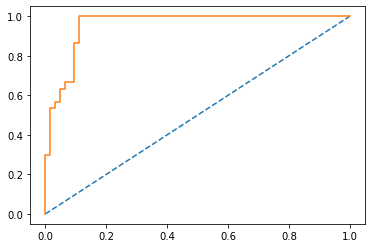

              precision    recall  f1-score   support

           0       1.00      0.84      0.91        63
           1       0.75      1.00      0.86        30

    accuracy                           0.89        93
   macro avg       0.88      0.92      0.89        93
weighted avg       0.92      0.89      0.90        93

Best Parameters:  {'class__C': 10, 'class__penalty': 'l2', 'class__solver': 'newton-cg'}


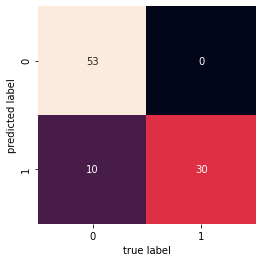

In [7]:
# Test parameter grid for best paramaters
scores = pd.DataFrame(columns={'Model', 'Score'})
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2']
c_values = [0.001,0.01,0.1, 1, 10]
random_grid = {'class__solver':solvers,'class__penalty':penalty, 'class__C':c_values}

# Perform GridSearch on parameter grid
score = gridSearchCV(LogisticRegression(random_state=42),random_grid, 
                       X_train, X_test, y_train, y_test, name='Smote LogReg')
scores.loc[1] = ("logreg", score)

## GRADIENT BOOSTING CLASSIFIER

area under curve (auc):  0.935978835978836


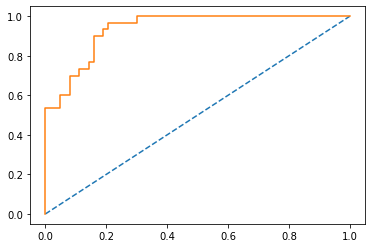

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        63
           1       0.70      0.77      0.73        30

    accuracy                           0.82        93
   macro avg       0.79      0.80      0.80        93
weighted avg       0.82      0.82      0.82        93

Best Parameters:  {'class__criterion': 'friedman_mse', 'class__learning_rate': 1, 'class__loss': 'exponential', 'class__n_estimators': 11}


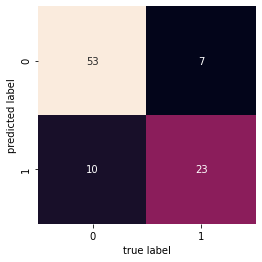

In [8]:
# Test parameter grid for best paramaters
loss = ['deviance', 'exponential']
lr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ne = range(1,100,5)
cr = ['friedman_mse', 'mse', 'mae']
random_grid = {'class__loss':loss,'class__learning_rate':lr,'class__n_estimators':ne, 'class__criterion':cr}

# Perform GridSearch on parameter grid
score = gridSearchCV(GradientBoostingClassifier(random_state=42), random_grid, 
             X_train, X_test, y_train, y_test, name='Smote GB')

scores.loc[2] = ("BGC", score)

## SUPPORT VECTOR MACHINE

              precision    recall  f1-score   support

           0       0.93      0.83      0.87        63
           1       0.70      0.87      0.78        30

    accuracy                           0.84        93
   macro avg       0.82      0.85      0.83        93
weighted avg       0.86      0.84      0.84        93

Best Parameters:  {'class__C': 10, 'class__gamma': 0.1, 'class__kernel': 'rbf'}


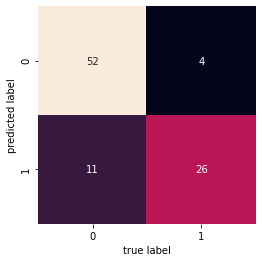

In [9]:
param_grid = {'class__C': [0.1, 1, 10, 100, 1000],  
              'class__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'class__kernel': ['rbf']}  

score = gridSearchCV(SVC(random_state=42), param_grid, 
             X_train, X_test, y_train, y_test, graph=2,name='Smote SVM')

scores.loc[3] = ("SVM", score)

## RANDOM FOREST CLASSIFIER

area under curve (auc):  0.9476190476190476


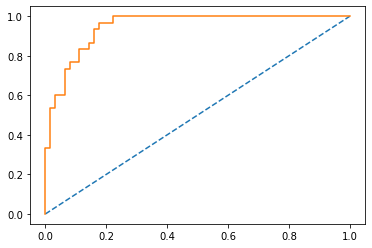

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        63
           1       0.72      0.93      0.81        30

    accuracy                           0.86        93
   macro avg       0.84      0.88      0.85        93
weighted avg       0.88      0.86      0.86        93

Best Parameters:  {'class__criterion': 'entropy', 'class__max_depth': 5, 'class__min_samples_leaf': 4, 'class__n_estimators': 32}


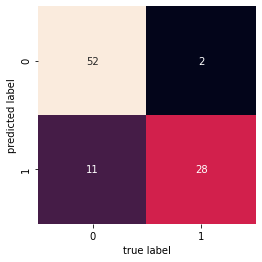

In [10]:
param_grid = {'class__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 
              'class__max_depth': range(1,32,1),
              'class__min_samples_leaf': [1, 2, 3, 4, 5], 
              'class__criterion': ['gini', 'entropy']}  

score = gridSearchCV(RandomForestClassifier(random_state=42), param_grid, 
             X_train, X_test, y_train, y_test, name='Smote RF')

scores.loc[4] = ("RandomForest", score)

## KNEIGHBORS CLASSIFIER

#### Base Measure without tuning

area under curve (auc):  0.8126984126984127


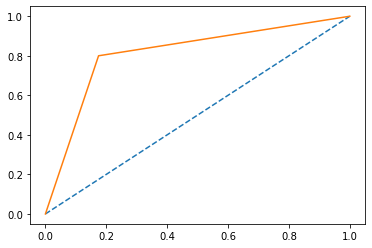

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        63
           1       0.69      0.80      0.74        30

    accuracy                           0.82        93
   macro avg       0.79      0.81      0.80        93
weighted avg       0.83      0.82      0.82        93

Best Parameters:  {'class__algorithm': 'auto', 'class__leaf_size': 1, 'class__n_neighbors': 1, 'class__p': 2, 'class__weights': 'uniform'}


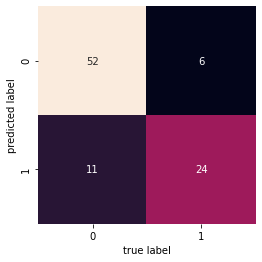

In [11]:
param_grid = {'class__algorithm': ['auto'], 
              'class__leaf_size': [1,5,10,15,20,25,30], 
             'class__n_neighbors':[1,2,3,4,5,6,7,8],
             'class__p':[1,2],
             'class__weights':['uniform','distance']}  

score = gridSearchCV(KNeighborsClassifier(), param_grid, 
                  X_train, X_test, y_train, y_test, name='Smote KNN')

scores.loc[5] = ("KNN", score)

### Gaussian Naive Bayes

area under curve (auc):  0.864021164021164


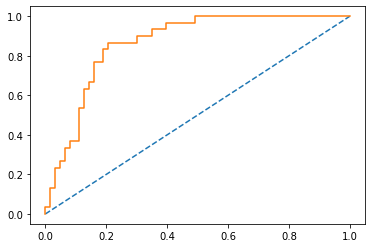

              precision    recall  f1-score   support

           0       0.92      0.75      0.82        63
           1       0.62      0.87      0.72        30

    accuracy                           0.78        93
   macro avg       0.77      0.81      0.77        93
weighted avg       0.82      0.78      0.79        93

Best Parameters:  {'class__var_smoothing': 0.1}


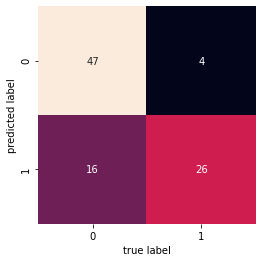

In [12]:
param_grid = {'class__var_smoothing':[1e-1,1e-9,1e-19,1e-29]}
score = gridSearchCV(GaussianNB(priors=None, ), param_grid, 
                  X_train, X_test, y_train, y_test, name='Smote NB')

scores.loc[6] = ("Naive Bayes", score)

In [13]:
print(scores)

          Score     Model
1        logreg  0.857143
2           BGC  0.730159
3           SVM  0.776119
4  RandomForest  0.811594
5           KNN  0.738462
6   Naive Bayes  0.722222
